# Import Library

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from scipy.stats import randint
from sklearn.metrics import roc_auc_score
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [2]:
df = pd.read_csv("churn.csv")
df.sample(5)

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3834,4039-HEUNW,Male,1.0,Yes,No,36.0,Month-to-month,Yes,Electronic check,96.50,3436.10,Yes
6345,3214-IYUUQ,Female,0.0,Yes,No,61.0,One year,No,Bank transfer (automatic),93.70,5860.70,No
5119,8199-ZLLSA,Male,0.0,No,No,67.0,One year,Yes,Bank transfer (automatic),118.35,7804.15,Yes
621,4851-BQDNX,Male,0.0,Yes,Yes,40.0,One year,Yes,Electronic check,85.05,3355.65,No
4264,2819-GWENI,Female,0.0,Yes,Yes,28.0,One year,No,Mailed check,19.90,543.00,No


# Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7046 entries, 0 to 7045
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7037 non-null   object 
 1   Gender            7030 non-null   object 
 2   SeniorCitizen     7034 non-null   float64
 3   Partner           7030 non-null   object 
 4   Dependents        7027 non-null   object 
 5   Tenure            7029 non-null   float64
 6   Contract          7033 non-null   object 
 7   PaperlessBilling  7033 non-null   object 
 8   PaymentMethod     7035 non-null   object 
 9   MonthlyCharges    7036 non-null   float64
 10  TotalCharges      7046 non-null   float64
 11  Churn             7046 non-null   object 
dtypes: float64(4), object(8)
memory usage: 660.7+ KB


### Missing value

In [4]:
df.isna().sum()

customerID           9
Gender              16
SeniorCitizen       12
Partner             16
Dependents          19
Tenure              17
Contract            13
PaperlessBilling    13
PaymentMethod       11
MonthlyCharges      10
TotalCharges         0
Churn                0
dtype: int64

In [5]:
total_missing = 0
for i in df.isna().sum():
    total_missing = total_missing+i
(total_missing/df.shape[0])*100

1.9301731478853252

Since the number of missing values is very small, the missing values can be removed.

In [6]:
df.dropna(inplace=True)
df.isna().sum()

customerID          0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Tenure              0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Duplicated Value

In [7]:
#Check duplicate value with ID table
df.duplicated(subset='customerID').sum()

13

In [8]:
# drop duplicated value
df.drop_duplicates(subset='customerID', keep='first', inplace=True)
df.duplicated(subset='customerID').sum()

0

### Drop the customerID column because it is not needed.

In [9]:
df.drop(columns='customerID', axis=1, inplace=True)

### Check Value Numerical

In [10]:
df[df['Tenure']<=0]

,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [11]:
df[df['MonthlyCharges']<=0]

,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [12]:
df[df['TotalCharges']<=0]

,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


There are no unnatural values in the numerical column.

# Data Exploration

In [13]:
numerical = []
categorical = []
for i in df.columns:
    if (df[i].dtypes == 'float64') or (df[i].dtypes == 'int64'):
        numerical.append(i)
    elif (df[i].dtypes != 'float64') and (df[i].dtypes != 'int64'):
        categorical.append(i)
print(numerical)
print(categorical)

['SeniorCitizen', 'Tenure', 'MonthlyCharges', 'TotalCharges']
['Gender', 'Partner', 'Dependents', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [14]:
df[numerical].describe()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges
count,6898.000000,6898.000000,6898.000000,6898.000000
mean,0.161931,32.433749,64.839439,2286.277320
std,0.368414,24.528786,30.100388,2265.938904
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.550000,401.150000
50%,0.000000,29.000000,70.400000,1400.700000
75%,0.000000,55.000000,89.900000,3807.837500
max,1.000000,72.000000,118.750000,8684.800000


* Min-max all values are making sense
* SeniorCitizen column is discrete
* Tenure, MonthlyCharges, and TotalCharges have a wide spread of data due to the large standard deviation based on their respective data scales.

In [15]:
df[categorical].describe()

,Gender,Partner,Dependents,Contract,PaperlessBilling,PaymentMethod,Churn
count,6898,6898,6898,6898,6898,6898,6898
unique,2,2,2,3,2,4,2
top,Male,No,No,Month-to-month,Yes,Electronic check,No
freq,3488,3573,4845,3803,4088,2309,5073


Most of column categorical have two categorik, and two columns have more than two categorik, that are Contract and PaymentMethod

### Distribution Data

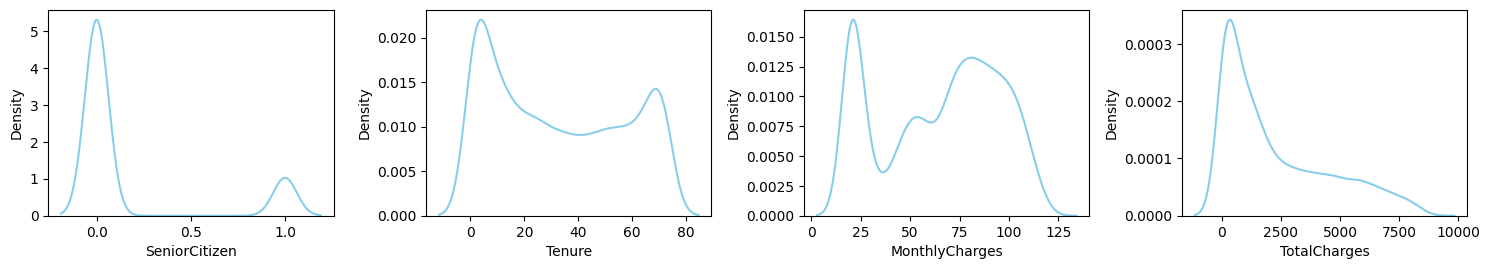

In [16]:
# adjust the figure size for better readability
plt.figure(figsize=(15,5))

features = numerical
for i in range(0, len(features)):
    plt.subplot(2, len(features)//2 + 2, i+1)
    sns.kdeplot(x=df[features[i]], color='skyblue')
    plt.xlabel(features[i])
    plt.tight_layout()

* customers has 2 group distribution of tenure, there are 1-2 month and around 70 month
* there are two group distribution of monthly charges, there take cheap monthly charges and expensive monthly charges
* most customers have less than 2000 total charges
* there is an imbalance in the data of senior citizen

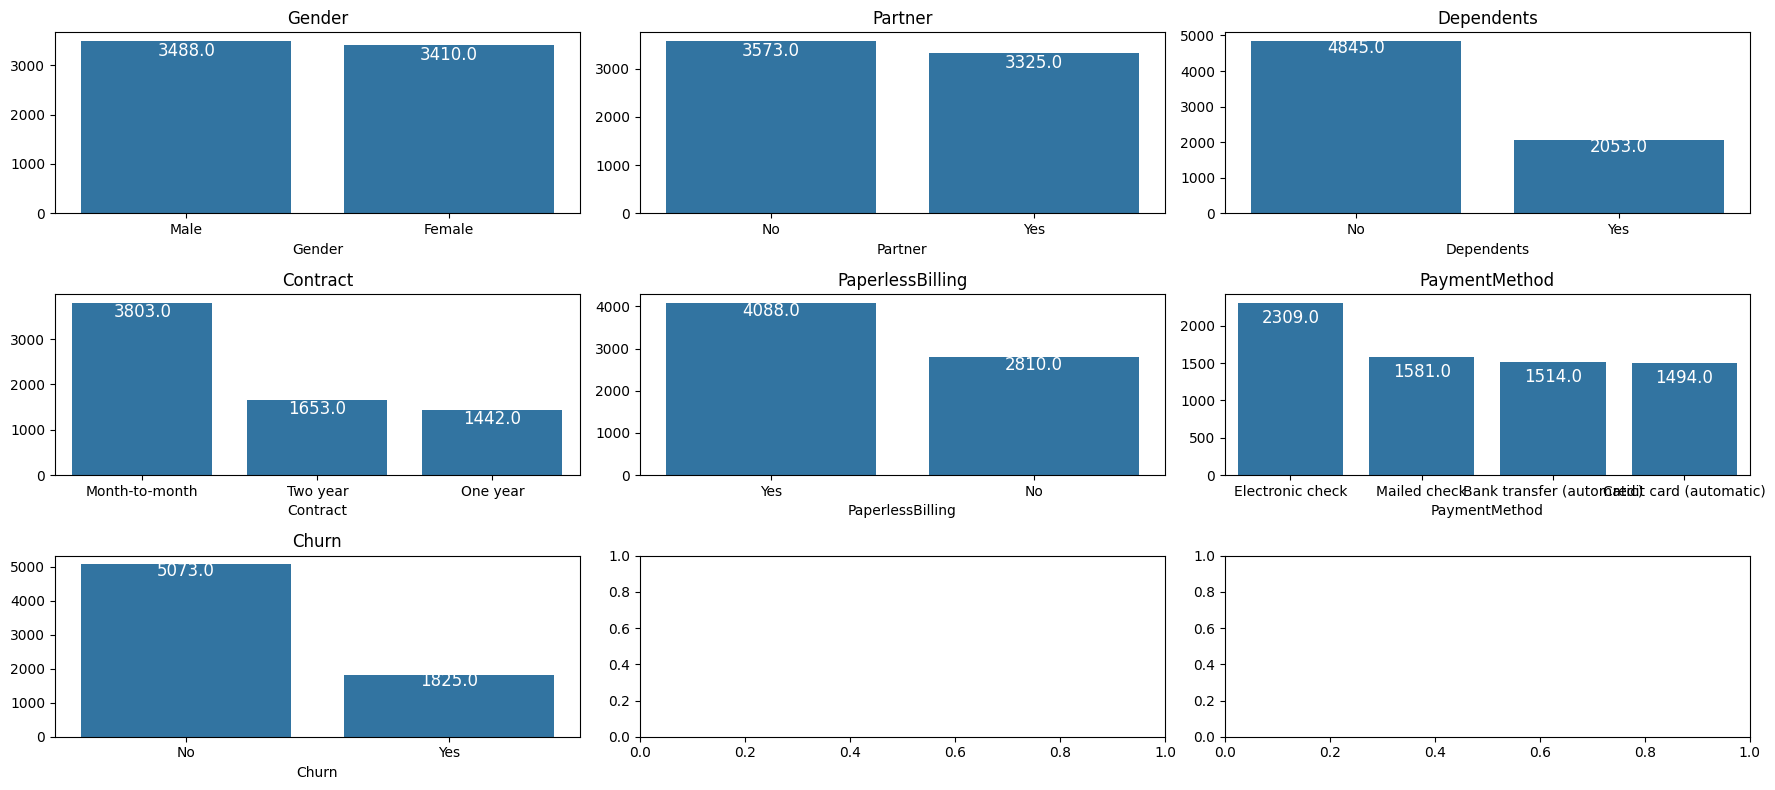

In [17]:
total_category = len(categorical)
row = 3
colom = 3

fig, axes = plt.subplots(row, colom, figsize=(18, 8))
for i, ax in enumerate(axes.flat):
    if i < total_category:
        sns.barplot(x=df[categorical[i]].value_counts().index, y=df[categorical[i]].value_counts().values, ax=ax)
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy()
            ax.annotate(f'{height}', (x + width / 2, y + height - 200), ha='center', va='center', fontsize=12, color='white')
        ax.set_title(categorical[i])

plt.tight_layout()
plt.show()

* Categorical features that are relatively balanced include: gender, partner, PaymentMethod.
* Categorical features that are relatively unbalanced include: Dependents, Contract, PaperlessBilling, Churn.

### Multivariate Analysis

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6898 entries, 1 to 7031
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            6898 non-null   object 
 1   SeniorCitizen     6898 non-null   float64
 2   Partner           6898 non-null   object 
 3   Dependents        6898 non-null   object 
 4   Tenure            6898 non-null   float64
 5   Contract          6898 non-null   object 
 6   PaperlessBilling  6898 non-null   object 
 7   PaymentMethod     6898 non-null   object 
 8   MonthlyCharges    6898 non-null   float64
 9   TotalCharges      6898 non-null   float64
 10  Churn             6898 non-null   object 
dtypes: float64(4), object(7)
memory usage: 646.7+ KB


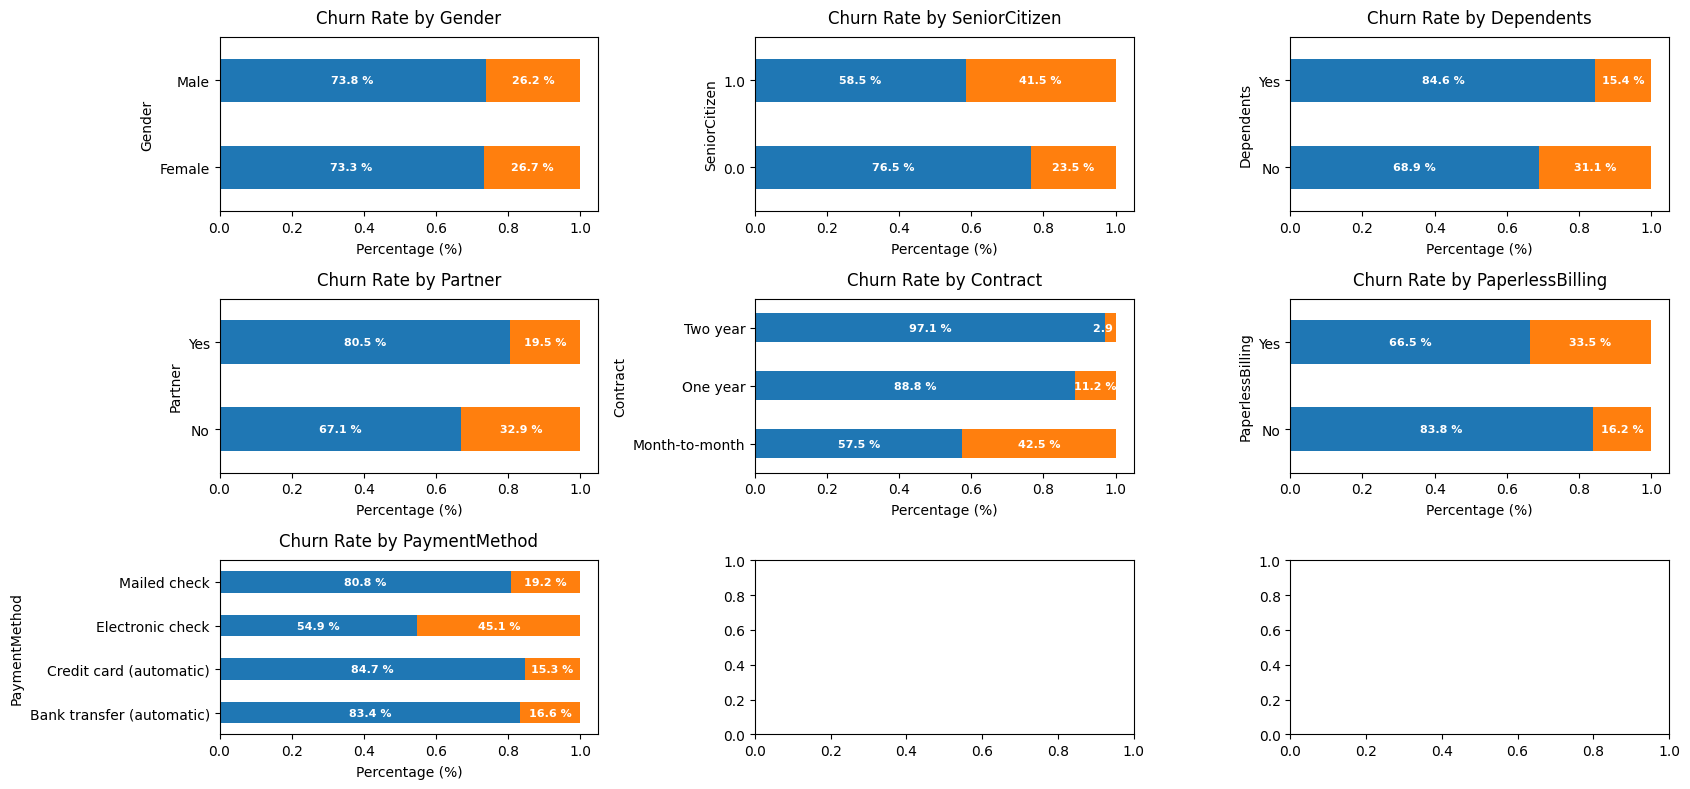

In [19]:
columns_to_plot = ['Gender', 'SeniorCitizen', 'Dependents', 'Partner', 'Contract', 'PaperlessBilling', 'PaymentMethod']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(17, 8))

for i, column in enumerate(columns_to_plot):
    ax = pd.crosstab(df[column], df['Churn'], normalize='index').plot.barh(stacked=True, ax = axes[i // 3, i % 3])
    ax.legend(bbox_to_anchor=(0.5, 0.5), title='Is Churn', fontsize=10, title_fontsize=10, labels=['No', 'Yes'], loc='lower left')
    ax.legend().remove()

    j = 1
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, y+height/2, '{:.1f} %'.format(width*100),  # Perhatikan perubahan di sini
                horizontalalignment='center', verticalalignment='center',
                color='white', fontsize=8, weight='bold')
        j += 1

    ax.set_title(f'Churn Rate by {column}', fontsize=12, pad=10)
    ax.set_xlabel('Percentage (%)', fontsize=10, labelpad=5)  # Perhatikan perubahan di sini
    ax.set_ylabel(column, fontsize=10)

plt.tight_layout()
plt.show()

* Male and female customers have no influence on churn. This column may not be used for the model.
* It looks that senior citizen have a high potential to churn.
* Customers who are not dependent have a higher churn rate than dependent customers.
* Customers who do not have partner have a higher churn rate than customer who do
* Customers who take yearly contracts are less likely to churn.
* It can be seen that customers who use paperless billing have a higher churn rate than those who do not.
* By PaymentMethod, customers with electronic checks potentially get a higher churn rate than customers with other methods.

In [20]:
df.drop(columns='Gender', inplace=True)

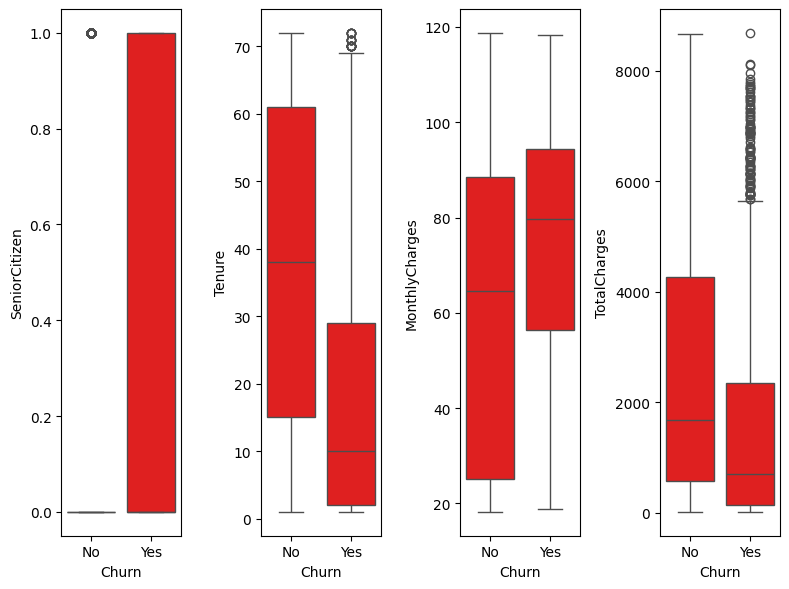

In [21]:
plt.figure(figsize=(8,6))

features = numerical
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(x = df['Churn'], y=df[features[i]], color='red')
    plt.tight_layout()

* we can see that people churn has low total charges than people not churn
* from boxplot value Q1, Q2 and Q3 monthlycharges customer churn > Q1, Q2, and Q3 customer not churn
* It can be seen that churn customers have a lower tenure compared to customers who do not churn.
* There are outliers in the TotalCharges column, but the values are still acceptable.

### Heatmap Correlation

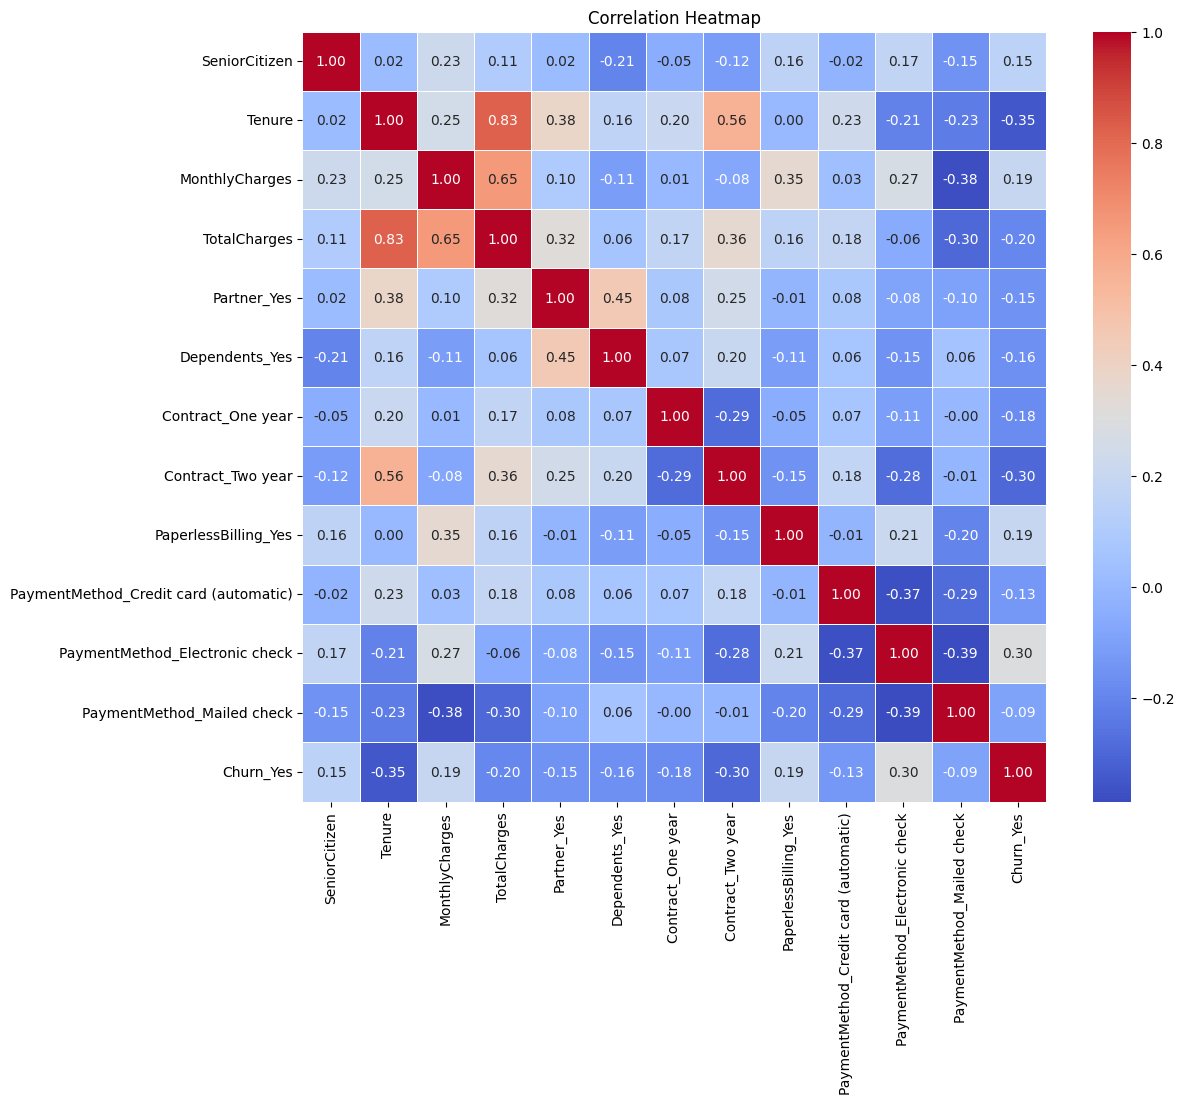

In [22]:
categorical_columns = ['Partner', 'Dependents', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

There seems to be a strong correlation between tenure and totalcharges. Therefore, one of the columns will be dropped, as multicollinearity can affect model performance. As the correlation between tenure and churn is higher than totalcharges, the totalcharges column will not be used for modeling.

In [23]:
df.drop(columns='TotalCharges', inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6898 entries, 1 to 7031
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     6898 non-null   float64
 1   Partner           6898 non-null   object 
 2   Dependents        6898 non-null   object 
 3   Tenure            6898 non-null   float64
 4   Contract          6898 non-null   object 
 5   PaperlessBilling  6898 non-null   object 
 6   PaymentMethod     6898 non-null   object 
 7   MonthlyCharges    6898 non-null   float64
 8   Churn             6898 non-null   object 
dtypes: float64(3), object(6)
memory usage: 538.9+ KB


# Feature Encoding and Scalling

### Encoding

In [25]:
df1 = df.copy()

In [26]:
value_mapping = {
    'No': 0,
    'Yes' : 1
}
df1['Churn'] = df1['Churn'].map(value_mapping)
df1[['Churn']]

,Churn
1,0
2,1
3,0
4,1
5,1
...,...
7027,0
7028,0
7029,0
7030,1


In [28]:
from sklearn.preprocessing import LabelEncoder
categorical_columns = ['Partner', 'Dependents', 'Contract', 'PaperlessBilling', 'PaymentMethod']
for i in categorical_columns:
    if df1[i].nunique() == 2:
        encode = LabelEncoder()
        encode.fit(df1[i])
        df1[i] = encode.transform(df1[i])
    else:
        df1 = pd.get_dummies(df1, columns=[i], drop_first=True)

In [29]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6898 entries, 1 to 7031
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          6898 non-null   float64
 1   Partner                                6898 non-null   int32  
 2   Dependents                             6898 non-null   int32  
 3   Tenure                                 6898 non-null   float64
 4   PaperlessBilling                       6898 non-null   int32  
 5   MonthlyCharges                         6898 non-null   float64
 6   Churn                                  6898 non-null   int64  
 7   Contract_One year                      6898 non-null   bool   
 8   Contract_Two year                      6898 non-null   bool   
 9   PaymentMethod_Credit card (automatic)  6898 non-null   bool   
 10  PaymentMethod_Electronic check         6898 non-null   bool   
 11  PaymentMe

### Feature Scalling

In [30]:
from sklearn.preprocessing import Normalizer
numeric_features = ['Tenure', 'MonthlyCharges']
scaler = Normalizer()
df1[numeric_features] = scaler.fit_transform(df1[numeric_features])
df1

,SeniorCitizen,Partner,Dependents,Tenure,PaperlessBilling,MonthlyCharges,Churn,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1,0.0,0,0,0.512610,0,0.858622,0,True,False,False,False,True
2,0.0,0,0,0.037115,1,0.999311,1,False,False,False,False,True
3,0.0,0,0,0.728628,0,0.684910,0,True,False,False,False,False
4,0.0,0,0,0.028277,1,0.999600,1,False,False,False,True,False
5,0.0,0,0,0.080024,1,0.996793,1,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.0,1,1,0.272322,1,0.962206,0,True,False,False,False,True
7028,0.0,1,1,0.572182,1,0.820127,0,True,False,True,False,False
7029,0.0,1,1,0.348346,1,0.937366,0,False,False,False,True,False
7030,1.0,1,0,0.053686,1,0.998558,1,False,False,False,False,True


In [31]:
X = df1.drop(columns='Churn', axis=1)
y = df1['Churn']
X.shape, y.shape

((6898, 11), (6898,))

# Imbalanced Data Handling

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [33]:
def sampler_compare(samplers, X_train, y_train, X_test, y_test):
    accus, accu_balanceds = [], []

    for sampler in samplers.values():
        X_train_balanced, y_train_balanced = sampler.fit_resample(X_train, y_train)
        
        # Test by logistic regression accuracy
        tree = LogisticRegression()
        clf = tree.fit(X_train, y_train)
        accu = roc_auc_score(y_test, clf.predict(X_test))
        clf_balanced = tree.fit(X_train_balanced, y_train_balanced)
        accu_balanced = roc_auc_score(y_test, clf_balanced.predict(X_test))

        accus.append(accu)
        accu_balanceds.append(accu_balanced)

    return accus, accu_balanceds

samplers = {'Undersample': RandomUnderSampler(random_state=42),
           'Oversample': RandomOverSampler(random_state=42),
           'SMOTE': SMOTE(random_state=42)}

accus, accu_balanceds = np.round(sampler_compare(samplers, X_train, y_train, X_test, y_test), 4)

In [34]:
# Output comparsion table
table = pd.DataFrame({"Balancing Method": samplers.keys(), 
                      "Accuracy (imbalanced)": accus, 
                      "Accuracy (balanced)": accu_balanceds})

pd.pivot_table(table, index=['Balancing Method']).sort_values(by="Accuracy (balanced)", ascending=False)

,Accuracy (balanced),Accuracy (imbalanced)
Balancing Method,,
Undersample,0.7441,0.6811
SMOTE,0.7428,0.6811
Oversample,0.7380,0.6811


It looks like the resampling method (undersample) has a higher score in accuracy (AUC score) than without resampling.

In [35]:
X_train_balanced, y_train_balanced = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)
print(X_train_balanced.shape)
print(y_train_balanced.shape)

(2870, 11)
(2870,)


# Modeling

In [36]:
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import roc_auc_score

def create_models(models, X_train, X_test, y_train, y_test):
    get_model, f1_scores, recall_scores, auc_scores = [], [], [], []
    for name, model in models.items():
        # Fit models
        if name == "XGBoost":
            X_train_np = X_train.to_numpy()
            y_train_np = y_train.to_numpy()
            clf = model.fit(X_train_np, y_train_np)
            y_prob = clf.predict_proba(X_test)[:, 1]
            y_pred = clf.predict(X_test) ; y_pred_train = clf.predict(X_train_np)
        else:
            clf = model.fit(X_train, y_train)
            y_prob = clf.predict_proba(X_test)[:, 1]
            y_pred = clf.predict(X_test) ; y_pred_train = clf.predict(X_train)
        # Evaluate metrics
        recall_model_result = round(recall_score(y_test, y_pred), 4); recall_train = round(recall_score(y_train, y_pred_train),4)
        f1 = round(f1_score(y_test, y_pred), 4); f1_train = round(f1_score(y_train, y_pred_train),4)
        auc = round(roc_auc_score(y_test, y_prob), 4);

        # Print Evaluation Metrics
        print("===================================================================================")
        print(f"Nama: {name}\nRecall Training: {recall_train}\nRecall Test: {recall_model_result}\nF1-Score Train: {f1_train}\nF1-Score Test: {f1}")
        print("===================================================================================")

        #Append values to list
        f1_scores.append(f1); auc_scores.append(auc)
        get_model.append(clf); recall_scores.append(recall_model_result)
    return get_model, f1_scores, recall_scores, auc_scores

def evaluate(models, f1_scores, recall_scores, auc_scores):
    table = pd.DataFrame({
        "Model": models.keys(),
        "AUC Score": auc_scores,
        "F1-Score": f1_scores,
        "Recall": recall_scores
    })
    result = table.set_index('Model').sort_values(by="Recall", ascending=False).reset_index()
    return result

Rationale for selecting the evaluation metrics used:
1. Recall: Recall measures the model's ability to identify all positive class instances. In the context of churn, this means identifying as many customers as possible who actually quit. High recall can help ensure that customers who quit are actually identified, allowing companies to take more effective and proactive retention actions.
2. AUC Score: The AUC Score provides an overall picture of the model's performance, not just at one particular point. It measures the model's ability to distinguish between positive and negative classes across various threshold levels. In churn prediction, where the balance between false positive rate (identifying customers who did not quit as quitters) and true positive rate (identifying customers who quit as quitters) is important, AUC Score provides a holistic picture of the model's capabilities.
3. F1-Score: F1-Score is a measure of the balance between precision and recall. A high F1-Score indicates a good balance between the model's ability to identify positive classes and avoid false positives. In the telecom industry, where the cost of retention and churn prevention efforts can be significant, having a good balance between retaining customers who quit and avoiding unnecessary efforts on customers who will not quit is important.

## Baseline Model

In [37]:
models = {'Logistic Regression': LogisticRegression(),
          'KNN Neighbors': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Random Forest': RandomForestClassifier(),
          'XGBoost': XGBClassifier()}

In [38]:
get_model, f1_scores, recall_scores, auc_scores = create_models(models, X_train_balanced, X_test, y_train_balanced, y_test)
result1 = evaluate(models, f1_scores, recall_scores, auc_scores)
result1

Nama: Logistic Regression
Recall Training: 0.8293
Recall Test: 0.7923
F1-Score Train: 0.7819
F1-Score Test: 0.618
Nama: KNN Neighbors
Recall Training: 0.8265
Recall Test: 0.7538
F1-Score Train: 0.814
F1-Score Test: 0.5957
Nama: Decision Tree
Recall Training: 0.9951
Recall Test: 0.6795
F1-Score Train: 0.9976
F1-Score Test: 0.5419
Nama: Random Forest
Recall Training: 0.9972
Recall Test: 0.7154
F1-Score Train: 0.9976
F1-Score Test: 0.5843
Nama: XGBoost
Recall Training: 0.8892
Recall Test: 0.7385
F1-Score Train: 0.8671
F1-Score Test: 0.6038


,Model,AUC Score,F1-Score,Recall
0,Logistic Regression,0.8147,0.6180,0.7923
1,KNN Neighbors,0.7747,0.5957,0.7538
2,XGBoost,0.7994,0.6038,0.7385
3,Random Forest,0.7821,0.5843,0.7154
4,Decision Tree,0.6783,0.5419,0.6795


* KNN, Decision Tree, Random Forest, and XGBoost models appear to be overfitting, as shown by the high trains values, but decrease significantly when tested with the test data.

## Hyperparameter Tuning

### Logistic Regression

In [42]:
param_dist = {
    'penalty': ['l1', 'l2', 'none'],
    'C': [0.01, 0.1, 1, 4, 9], 
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 400, 500],
    'class_weight': ['balanced'],
}
lr_model = LogisticRegression()
lr_cv = GridSearchCV(
    estimator=lr_model, param_grid=param_dist,
    cv=5, scoring='recall', n_jobs=-1,
    return_train_score=True, verbose=5
)
lr_cv.fit(X_train, y_train)
print("Best parameters (LG): {}".format(lr_cv.best_params_))

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best parameters (LG): {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


### K-Nearest Neighbors (KNN) 

In [43]:
param_dist = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}
knn_model = KNeighborsClassifier()
knn_cv = GridSearchCV(
    estimator=knn_model, param_grid=param_dist,
    cv=5, scoring='recall', n_jobs=-1,
    return_train_score=True, verbose=10
)
knn_cv.fit(X_train, y_train)
print("Best parameters (KNN): {}".format(knn_cv.best_params_))

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters (KNN): {'algorithm': 'auto', 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}


### Random Forest

In [ ]:
param_dist = {
    'n_estimators': np.arange(50, 201, 10),
    'max_depth': [None] + list(np.arange(10, 31, 1)),
    'min_samples_split': np.arange(2, 11, 1),
    'min_samples_leaf': np.arange(1, 5, 1),
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.1, 0.1)),
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced'],
    'random_state': [42],
}
rf_model = RandomForestClassifier(random_state=42)
rf_cv = RandomizedSearchCV(
    estimator=rf_model, param_distributions=param_dist,
    cv=5, scoring='recall', n_jobs=-1, n_iter=100,
    return_train_score=True, verbose=5
)
rf_cv.fit(X_train, y_train)
print("Best parameters (RF): {}".format(rf_cv.best_params_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters (RF): {'random_state': 42, 'n_estimators': 70, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 0.1, 'max_depth': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}


### XGBoost

In [ ]:
param_dist = {
    'learning_rate': np.arange(0.01, 0.31, 0.01),
    'n_estimators': np.arange(50, 201, 50),
    'max_depth': np.arange(3, 8),
    'subsample': np.arange(0.8, 1.1, 0.1),
    'colsample_bytree': np.arange(0.8, 1.1, 0.1),
    'gamma': np.arange(0, 0.5, 0.1),
    'min_child_weight': np.arange(1, 5),
    'scale_pos_weight': np.arange(1, 4),
}
xgb_model = XGBClassifier()
xgb_cv = RandomizedSearchCV(
    estimator=xgb_model, param_distributions=param_dist,
    cv=5, scoring='recall', n_jobs=-1, n_iter=100,
    return_train_score=True, verbose=10
)
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
xgb_cv.fit(X_train_np, y_train_np)
print("Best parameters (XGB): {}".format(xgb_cv.best_params_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters (XGB): {'subsample': 1.0, 'scale_pos_weight': 3, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.06999999999999999, 'gamma': 0.1, 'colsample_bytree': 1.0}


Define model with best hyperparameter

In [49]:
models = {'Logistic Regression_Tuned': LogisticRegression(C=0.1, 
                                                           class_weight='balanced',
                                                           max_iter=100,
                                                           penalty='l2',
                                                           solver='liblinear'),
          'Random Forest_Tuned': RandomForestClassifier(criterion='entropy',
                                                        max_depth=10,
                                                        max_features=0.1,
                                                        n_estimators=70,
                                                        random_state=42,
                                                        min_samples_split=6,
                                                        min_samples_leaf=4,
                                                        class_weight='balanced'),
          'XGBoost_Tuned': XGBClassifier(subsample=1,
                                         scale_pos_weight=3,
                                         n_estimators=100, 
                                         min_child_weight=1, 
                                         max_depth=3, 
                                         learning_rate=0.06999999999999999, 
                                         gamma=0.1, 
                                         colsample_bytree=1.0),
          'KNN Neighbors_Tuned':KNeighborsClassifier(weights='uniform',
                                                     p=2,
                                                     n_neighbors=7,
                                                     algorithm='auto')}

In [50]:
get_model_tuned, f1_scores_tuned, recall_scores_tuned, auc_scores_tuned= create_models(models, X_train_balanced, X_test, y_train_balanced, y_test)
result2 = evaluate(models, f1_scores_tuned, recall_scores_tuned, auc_scores_tuned)
result2

Nama: Logistic Regression_Tuned
Recall Training: 0.8307
Recall Test: 0.8026
F1-Score Train: 0.7804
F1-Score Test: 0.6161
Nama: Random Forest_Tuned
Recall Training: 0.8474
Recall Test: 0.7692
F1-Score Train: 0.8156
F1-Score Test: 0.611
Nama: XGBoost_Tuned
Recall Training: 0.9498
Recall Test: 0.9282
F1-Score Train: 0.7806
F1-Score Test: 0.5719
Nama: KNN Neighbors_Tuned
Recall Training: 0.8265
Recall Test: 0.759
F1-Score Train: 0.8014
F1-Score Test: 0.5926


,Model,AUC Score,F1-Score,Recall
0,XGBoost_Tuned,0.8211,0.5719,0.9282
1,Logistic Regression_Tuned,0.8123,0.6161,0.8026
2,Random Forest_Tuned,0.8133,0.6110,0.7692
3,KNN Neighbors_Tuned,0.7772,0.5926,0.7590


* Model performance, measured by recall metrics, improved overall after hyperparameter tuning.
* Since the model is tuned based on the "recall" performance, there is a trade-off on the value of false positives, causing the "f1-score" to not differ too much from the base model.

# Evaluation

In [41]:
result = pd.concat([result1, result2], axis=0)
result.set_index('Model').sort_values(by='Recall',ascending=False).reset_index()

,Model,AUC Score,F1-Score,Recall
0,XGBoost_Tuned,0.8211,0.5719,0.9282
1,Logistic Regression_Tuned,0.8123,0.6161,0.8026
2,Logistic Regression,0.8147,0.6180,0.7923
3,Random Forest_Tuned,0.8133,0.6110,0.7692
4,KNN Neighbors_Tuned,0.7765,0.5978,0.7564
5,KNN Neighbors,0.7747,0.5957,0.7538
6,XGBoost,0.7994,0.6038,0.7385
7,Random Forest,0.7821,0.5843,0.7154
8,Decision Tree,0.6783,0.5419,0.6795


If the main priority is usually to increase **recall** to minimize false negatives (identifying customers who actually quit as non-churners) then the **XGBoost_Tuned** model is best as it has an excellent recall of 0.9282. However if **balancing** with other metrics such as not being too aggressive in predicting churn the **Logistic Regression_Tuned** model can be a good choice.